# Trump Twitter Sentiment Analysis 

In this notebook, I will walk through how I went about doing sentiment analysis on Trump's Tweets, using Twitter API's to extract his tweets. I also use various tools such as Pandas to make data analysis easier. 

In [1]:
# Run this cell to set up your notebook
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set()
sns.set_context("talk")
import re

from IPython.display import display, Latex, Markdown
from client.api.notebook import Notebook


<br/><br/><br/>

# Getting the Dataset

---

Since we'll be looking at Twitter data, we need to download the data from Twitter!

Twitter provides an API for downloading tweet data in large batches.  The `tweepy` package makes it fairly easy to use.

#### Setup
Install `tweepy`, if you don't already have it.  (Be sure to activate your Conda environment for the class first.  Then run `pip install tweepy`.)

In [3]:
## Make sure you are in your ds100 conda environment.
## Uncomment the following line to install tweepy
!pip install tweepy

  Using cached tweepy-3.5.0-py2.py3-none-any.whl
  Using cached requests_oauthlib-0.8.0-py2.py3-none-any.whl
    100% |████████████████████████████████| 133kB 1.4MB/s ta 0:00:01
  Running setup.py bdist_wheel for oauthlib ... done
  Stored in directory: /home/jovyan/.cache/pip/wheels/e5/46/f7/bb2fde81726295a13a71e3c6396d362ab408921c6562d6efc0
Successfully built oauthlib


In [4]:
# The following should run
import tweepy

There are instructions on using `tweepy` [here](http://tweepy.readthedocs.io/en/v3.5.0/getting_started.html), but we will give you example code.

Twitter requires you to have authentication keys to access their API.  To get your keys, you'll have to sign up as a Twitter developer.  The next question will walk you through this process.

---
<br/><br/>

## Getting Started

Follow the instructions below to get your Twitter API keys.  Read the instructions completely before starting.

1. [Create a Twitter account](https://twitter.com).  You can use an existing account if you have one.
2. Under account settings, add your phone number to the account.
3. [Create a Twitter developer account](https://dev.twitter.com/resources/signup).  Attach it to your Twitter account.
4. Once you're logged into your developer account, [create an application for this assignment](https://apps.twitter.com/app/new).  You can call it whatever you want, and you can write any URL when it asks for a web site.
5. On the page for that application, find your Consumer Key and Consumer Secret.
6. On the same page, create an Access Token.  Record the resulting Access Token and Access Token Secret.
7. Edit the file [keys.json](keys.json) and replace the placeholders with your keys.  Don't turn in that file.


## WARNING (Please Read) !!!!


### Protect your Twitter Keys
<span style="color:red">
If someone has your authentication keys, they can access your Twitter account and post as you!  So don't give them to anyone, and **don't write them down in this notebook**. 
</span>
The usual way to store sensitive information like this is to put it in a separate file and read it programmatically.  That way, you can share the rest of your code without sharing your keys.  That's why we're asking you to put your keys in `keys.json` for this assignment.


### Avoid making too many API calls.

<span style="color:red">
Twitter limits developers to a certain rate of requests for data.  If you make too many requests in a short period of time, you'll have to wait awhile (around 15 minutes) before you can make more.  </span> 
So carefully follow the code examples you see and don't rerun cells without thinking.  Instead, always save the data you've collected to a file.  We've provided templates to help you do that.


### Be careful about which functions you call!

<span style="color:red">
This API can retweet tweets, follow and unfollow people, and modify your twitter settings.  Be careful which functions you invoke! </span> One of your instructors accidentally re-tweeted some tweets because that instructor typed `retweet` instead of `retweet_count`. 
</span>


In [5]:
import json
key_file = 'keys.json'
# Loading your keys from keys.json (which you should have filled
# in in question 1):
with open(key_file) as f:
    keys = json.load(f)

This cell tests the Twitter authentication. It should run without errors or warnings and display your Twitter username.

In [6]:
import tweepy
from tweepy import TweepError
import logging

try:
    auth = tweepy.OAuthHandler(keys["consumer_key"], keys["consumer_secret"])
    auth.set_access_token(keys["access_token"], keys["access_token_secret"])
    api = tweepy.API(auth)
    print("Your username is:", api.auth.get_username())
except TweepError as e:
    logging.warning("There was a Tweepy error. Double check your API keys and try again.")
    logging.warning(e)

Your username is: saranshg23


---
<br/><br/>


## Extracting and Saving the Tweet Data

The code below will load in the data, and save it to a local file cache, which will make it faster for us to access later on and prevent us from having to call the data using Twitter API's everytime, which can be slow. 

In [9]:
def load_keys(path):
    """Loads your Twitter authentication keys from a file on disk.
    
    Args:
        path (str): The path to your key file.  The file should
          be in JSON format and look like this (but filled in):
            {
                "consumer_key": "<your Consumer Key here>",
                "consumer_secret":  "<your Consumer Secret here>",
                "access_token": "<your Access Token here>",
                "access_token_secret": "<your Access Token Secret here>"
            }
    
    Returns:
        dict: A dictionary mapping key names (like "consumer_key") to
          key values."""
    with open (path) as f:
        keys = json.load(f)
    return keys

In [10]:
def download_recent_tweets_by_user(user_account_name, keys):
    """Downloads tweets by one Twitter user.

    Args:
        user_account_name (str): The name of the Twitter account
          whose tweets will be downloaded.
        keys (dict): A Python dictionary with Twitter authentication
          keys (strings), like this (but filled in):
            {
                "consumer_key": "<your Consumer Key here>",
                "consumer_secret":  "<your Consumer Secret here>",
                "access_token": "<your Access Token here>",
                "access_token_secret": "<your Access Token Secret here>"
            }

    Returns:
        list: A list of Status objects, each representing one tweet."""
    auth = tweepy.OAuthHandler(keys["consumer_key"], keys["consumer_secret"])
    auth.set_access_token(keys["access_token"], keys["access_token_secret"])
    api = tweepy.API(auth)
    # Getting as many recent tweets by @user_account_name as Twitter will let us have:
    tweets = list(tweepy.Cursor(api.user_timeline, id=user_account_name).items())
    return tweets

In [11]:
def save_tweets(tweets, path):
    """Saves a list of tweets to a file in the local filesystem.
    
    This function makes no guarantee about the format of the saved
    tweets, **except** that calling load_tweets(path) after
    save_tweets(tweets, path) will produce the same list of tweets
    and that only the file at the given path is used to store the
    tweets.  (That means you can implement this function however
    you want, as long as saving and loading works!)

    Args:
        tweets (list): A list of tweet objects (of type Status) to
          be saved.
        path (str): The place where the tweets will be saved.

    Returns:
        None"""
    with open(path, "wb") as f:
        import pickle
        pickle.dump(tweets, f)

In [12]:
def load_tweets(path):
    """Loads tweets that have previously been saved.
    
    Calling load_tweets(path) after save_tweets(tweets, path)
    will produce the same list of tweets.
    
    Args:
        path (str): The place where the tweets were be saved.

    Returns:
        list: A list of Status objects, each representing one tweet."""
    with open(path, "rb") as f:
        import pickle
        tweets = pickle.load(f)
    return tweets

In [13]:
def get_tweets_with_cache(user_account_name, keys_path):
    """Get recent tweets from one user, loading from a disk cache if available.
    
    The first time you call this function, it will download tweets by
    a user.  Subsequent calls will not re-download the tweets; instead
    they'll load the tweets from a save file in your local filesystem.
    All this is done using the functions you defined in the previous cell.
    This has benefits and drawbacks that often appear when you cache data:
    
    +: Using this function will prevent extraneous usage of the Twitter API.
    +: You will get your data much faster after the first time it's called.
    -: If you really want to re-download the tweets (say, to get newer ones,
       or because you screwed up something in the previous cell and your
       tweets aren't what you wanted), you'll have to find the save file
       (which will look like <something>_recent_tweets.pkl) and delete it.
    
    Args:
        user_account_name (str): The Twitter handle of a user, without the @.
        keys_path (str): The path to a JSON keys file in your filesystem.
    """
    keys = load_keys(keys_path)
    if Path(user_account_name + "_recent_tweets.pkl").exists():
        return load_tweets(user_account_name + "_recent_tweets.pkl")
    else:
        tweets = download_recent_tweets_by_user(user_account_name, keys)
        save_tweets(tweets, user_account_name + "_recent_tweets.pkl")
        return tweets 

    
    

If everything was implemented correctly you should be able to obtain roughly the last 3000 tweets by the `realdonaldtrump`.

In [14]:
# When you are done, run this cell to load @realdonaldtrump's tweets.
# Note the function get_tweets_with_cache.  You may find it useful
# later.
trump_tweets = get_tweets_with_cache("realdonaldtrump", key_file)
print("Number of tweets downloaded:", len(trump_tweets))

Number of tweets downloaded: 3242


---
<br/><br/>

## Exploring the Data with Pandas DataFrames

I will now extract important fields from the tweet objects and convert them into a Pandas dataframe for further analysis.

Each trump tweet is stored in a `tweepy.models.Status` object:

In [15]:
type(trump_tweets[0])

tweepy.models.Status

We can list all the members of this object by looking at the private `__dict__` variable:

In [16]:
list(trump_tweets[0].__dict__.keys())

['_json',
 'created_at',
 'id',
 'id_str',
 'text',
 'truncated',
 'entities',
 'source',
 'source_url',
 'in_reply_to_status_id',
 'in_reply_to_status_id_str',
 'in_reply_to_user_id',
 'in_reply_to_user_id_str',
 'in_reply_to_screen_name',
 'author',
 'user',
 'geo',
 'coordinates',
 'place',
 'contributors',
 'retweeted_status',
 'is_quote_status',
 'retweet_count',
 'favorite_count',
 'favorited',
 'retweeted',
 'lang']

Therefore we can extract a field simply by reading its value:

In [17]:
trump_tweets[0].text

'RT @ricardorossello: Briefed @POTUS @realDonaldTrump in #SituationRoom and thanked him for his leadership, quick response &amp; commitment to o…'

### Constructing the DataFrame

I will now construct a DataFrame called `trump`. The index of the dataframe should be the ID of each tweet (looks something like `907698529606541312`). It should have these columns:

- `time`: The time the tweet was created.
- `source`: The source device of the tweet.
- `text`: The text of the tweet.
- `retweet_count`: The retweet count of the tweet. 

In [18]:
trumps=trump_tweets

In [19]:
trump = pd.DataFrame({'retweet_count': [t.retweet_count for t in trumps], 'text': [t.text for t in trumps], 
                      'source': [t.source for t in trumps], 'time': [t.created_at for t in trumps]})
trump.index = [t.id_str for t in trumps]
trump.head(20)

,retweet_count,source,text,time
912771708544802823,829,Twitter for iPhone,RT @ricardorossello: Briefed @POTUS @realDonal...,2017-09-26 20:11:48
912711807709667331,3956,Twitter for iPhone,Honored to welcome Republican and Democrat mem...,2017-09-26 16:13:46
912670906828443648,4083,Twitter for iPhone,"ALABAMA, get out and vote for Luther Strange -...",2017-09-26 13:31:15
912664574461120512,13407,Twitter for iPhone,The NFL has all sorts of rules and regulations...,2017-09-26 13:06:05
912651215997202432,9860,Twitter for iPhone,"Thank you to Carmen Yulin Cruz, the Mayor of S...",2017-09-26 12:13:00
912636538156146688,8789,Twitter for iPhone,Great interview on @foxandfriends with the par...,2017-09-26 11:14:41
912631781098221568,4314,Twitter for iPhone,Luther Strange has been shooting up in the Ala...,2017-09-26 10:55:47
912629775629418501,11730,Twitter for iPhone,But while Dallas dropped to its knees as a tea...,2017-09-26 10:47:49
912626731357540353,16992,Twitter for iPhone,The booing at the NFL football game last night...,2017-09-26 10:35:43
912624892239077376,13958,Twitter for iPhone,Ratings for NFL football are way down except b...,2017-09-26 10:28:24


Here are two important dates that we'll use in our analysis. `ELEC_DATE` is the date when Trump won the 2016 Presidential election, and `INAUG_DATE` is the date that Trump was sworn into office.

In [21]:
from datetime import datetime

ELEC_DATE = datetime(2016, 11, 8)
INAUG_DATE = datetime(2017, 1, 20)

Here are the first and last rows of your tweet data.

You'll notice that the data contains tweets from before the election.

In [22]:
trump.iloc[[0, -1], :]

,retweet_count,source,text,time
912771708544802823,829,Twitter for iPhone,RT @ricardorossello: Briefed @POTUS @realDonal...,2017-09-26 20:11:48
758731880183193601,6239,Twitter for Android,"""@LallyRay: Poll: Donald Trump Sees 17-Point P...",2016-07-28 18:32:31


## Tweet Source Analysis

I am now going to find out the charateristics of Trump tweets and the devices used for the tweets.

---
<br/><br/>

## Unique Sources 

This code will find out the number of unique sources of the Trump tweets and save the result in `num_sources`. 

Then, I'll make a bar plot of the counts of different sources to visualize the data.

In [23]:
source = trump['source']

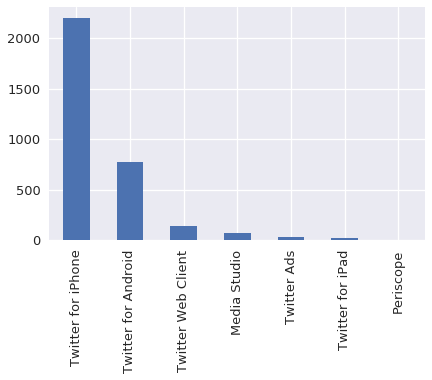

In [24]:
num_sources = source.nunique()
num_each = pd.value_counts(source)
# make a bar plot here
num_each.plot.bar()


As we can see from the plot above, Trump tweets are mostly from iPhone or Android. Is there a difference between his Tweet behavior between the two devices?

We will attempt to answer this question in our subsequent analysis.

First, we'll take a look at whether Trump's tweets from an Android come at different times than his tweets from an iPhone. Note that Twitter gives us his tweets in the [UTC timezone](https://www.wikiwand.com/en/List_of_UTC_time_offsets):

In [26]:
print(trump_tweets[0]._json['created_at'])

Tue Sep 26 20:11:48 +0000 2017


We'll convert the tweet times to US Eastern Time, the timezone of New York and Washington D.C., since those are the places we would expect the most tweet activity from Trump.

In [27]:
trump['est_time'] = pd.Index(trump['time']).tz_localize("UTC").tz_convert("US/Eastern")
trump.head()

,retweet_count,source,text,time,est_time
912771708544802823,829,Twitter for iPhone,RT @ricardorossello: Briefed @POTUS @realDonal...,2017-09-26 20:11:48,2017-09-26 16:11:48-04:00
912711807709667331,3956,Twitter for iPhone,Honored to welcome Republican and Democrat mem...,2017-09-26 16:13:46,2017-09-26 12:13:46-04:00
912670906828443648,4083,Twitter for iPhone,"ALABAMA, get out and vote for Luther Strange -...",2017-09-26 13:31:15,2017-09-26 09:31:15-04:00
912664574461120512,13407,Twitter for iPhone,The NFL has all sorts of rules and regulations...,2017-09-26 13:06:05,2017-09-26 09:06:05-04:00
912651215997202432,9860,Twitter for iPhone,"Thank you to Carmen Yulin Cruz, the Mayor of S...",2017-09-26 12:13:00,2017-09-26 08:13:00-04:00


---
<br/><br/>

## Plotting Tweet Timinfs By Device

I will use this data to make a line plot with two curves:

1. The number of iPhone tweets vs. hour of the day, normalized over the hours of the day. For example, if there were 10 tweets at 1pm and 20 tweets at 2pm, the line plot should be 0, then 0.33 at 1pm, 0.66 at 2pm, then back to 0.
2. The same curve for Android tweets.


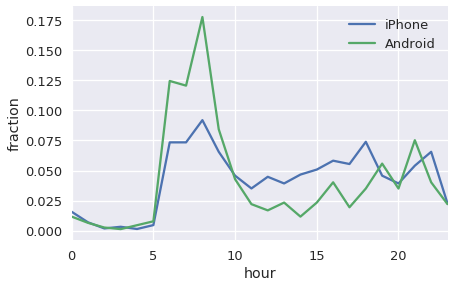

In [28]:
a = trump[trump['source'] == 'Twitter for iPhone']
b = trump[trump['source'] == 'Twitter for Android']
iPhone = a.groupby(trump['est_time'].dt.hour).size()/2165
Android = b.groupby(trump['est_time'].dt.hour).size()/771
iPhone.plot(label = "iPhone")
Android.plot(label = "Android")
plt.legend()
plt.xlabel("hour")
plt.ylabel("fraction")

--- 
<br></br>

## Analyzing the Results
Trump seems to tweet the most between hours 5 and 10 in the morning. Trump seems to tweet through the iPhone at around the same general proportion during normal hours throughout the day.
However, a large proportion of his Android tweets happen in the early hours, which means maybe he uses his Android more when he is travelling to certain places.

--- 
<br></br>

Let's now look at his tweet device usage over the entire time period we have in the dataset.

Take a look at the code below and the plot it generates.

You should be answer the following questions about this code. You don't have to write the answers down anywhere, but you'll need to make variations of this plot in later questions so understanding this code will help you greatly.

1. What does `set_index` do here?
1. What does `resample` do? What does the `'D'` argument do in `resample`?
1. What does `unstack` do? What does the `level=0` argument do in unstack?
1. Why does one call to `plot()` generate 7 lines?

Feel free to copy this cell, play around with the code to see the intermediate result, then delete your cell after you're done.

In [30]:
#1. set_index gives a basis for the x-axis. 
#2. resample means that we resample into bins, and the D means the bins are by the day. 
#3. unstack 
#4. plot calls 7 lines b/c it groups by source, and there are 7 different sources, so 1 line for each different source. 

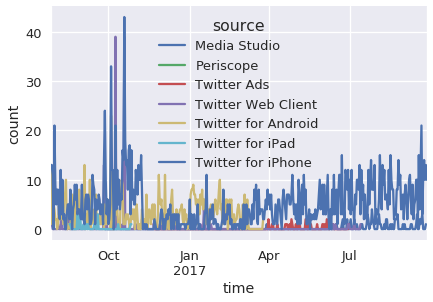

In [31]:
(trump.loc[:, ['est_time', 'source']]
 .set_index('est_time')
 .groupby('source')
 .resample('D')
 .size()
 .unstack(level=0)
 .plot()
)
plt.xlabel('time')
plt.ylabel('count')

## Cleaning the Plot

One problem with the plot above is that it plots too many points to see overall trends in the device usage.

Thus, I will recreate the plot above, grouping by each month instead of each day. 

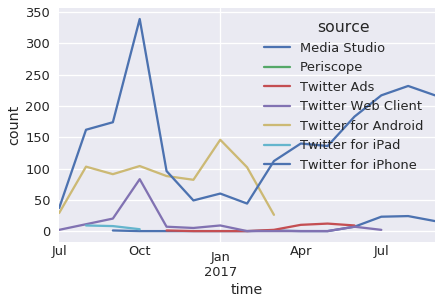

In [32]:
(trump.loc[:, ['est_time', 'source']]
 .set_index('est_time')
 .groupby('source')
 .resample('M')
 .size()
 .unstack(level=0)
 .plot()
)
plt.xlabel('time')
plt.ylabel('count')
plt.figure(figsize=(50,30))

According to the plot, Trump's tweets come from many different sources. It turns out that many of his tweets were not from Trump himself but from his staff. [Take a look at this Verge article.](https://www.theverge.com/2017/3/29/15103504/donald-trump-iphone-using-switched-android)

Does the data support the information in the article? What else do you find out about changes in Trump's tweets sources from the plot?

Yes, Trump tweets from many different sources, but it seems to be concentrated to a few main ones. The info in the article is also supported by this data because Trump has indeed essentially stopped posting from his Android since March according to the plot. However, this might mean that many of his tweets from iPhone before March were not actually from him but from his staff members, as Trump mainly used his Android to post his own tweets before. Likewise, his usage of using his iPhone has gone up significantly after stopping use of the Android, which makes sense because he has one less medium since he stopped using the Android. It also seems every medium other than the iPhone and Media Studio has decreased, while those 2 has increased according to the plot.

What are some ways we can distinguish between tweets that came from Trump and tweets from his staff? Before, it was as easy as checked which device the tweet came from. Now, we have to rely on more sophisticated methods.

---
<br></br>

## Sentiment Analysis

It turns out that we can use the words in Trump's tweets to calculate a measure of the sentiment of the tweet. For example, the sentence "I love America!" has positive sentiment, whereas the sentence "I hate taxes!" has a negative sentiment. In addition, some words have stronger positive / negative sentiment than others: "I love America." is more positive than "I like America."

We will use the [VADER (Valence Aware Dictionary and sEntiment Reasoner)](https://github.com/cjhutto/vaderSentiment) lexicon to analyze the sentiment of Trump's tweets. VADER is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media which is great for our usage.

The VADER lexicon gives the sentiment of individual words. Run the following cell to show the first few rows of the lexicon:

In [35]:
!head vader_lexicon.txt

$:	-1.5	0.80623	[-1, -1, -1, -1, -3, -1, -3, -1, -2, -1]
%)	-0.4	1.0198	[-1, 0, -1, 0, 0, -2, -1, 2, -1, 0]
%-)	-1.5	1.43178	[-2, 0, -2, -2, -1, 2, -2, -3, -2, -3]
&-:	-0.4	1.42829	[-3, -1, 0, 0, -1, -1, -1, 2, -1, 2]
&:	-0.7	0.64031	[0, -1, -1, -1, 1, -1, -1, -1, -1, -1]
( '}{' )	1.6	0.66332	[1, 2, 2, 1, 1, 2, 2, 1, 3, 1]
(%	-0.9	0.9434	[0, 0, 1, -1, -1, -1, -2, -2, -1, -2]
('-:	2.2	1.16619	[4, 1, 4, 3, 1, 2, 3, 1, 2, 1]
(':	2.3	0.9	[1, 3, 3, 2, 2, 4, 2, 3, 1, 2]
((-:	2.1	0.53852	[2, 2, 2, 1, 2, 3, 2, 2, 3, 2]


---
<br/><br/>

## Lexicon DataFrame

As you can see, the lexicon contains emojis too! The first column of the lexicon is the *token*, or the word itself. The second column is the *polarity* of the word, or how positive / negative it is.

(How did they decide the polarities of these words? What are the other two columns in the lexicon? See the link above.)

 Read in the lexicon into a DataFrame called `sent`. The index of the DF should be the tokens in the lexicon. `sent` should have one column: `polarity`: The polarity of each token.

In [36]:
sent = pd.read_csv('vader_lexicon.txt', sep ="	", header = None, error_bad_lines = False)
sent.columns = ["word", "polarity", "c", "d"]
sent = sent[["word", "polarity"]]
sent.index = sent["word"]
sent = sent[["polarity"]]
sent

,polarity
word,
$:,-1.5
%),-0.4
%-),-1.5
&-:,-0.4
&:,-0.7
( '}{' ),1.6
(%,-0.9
('-:,2.2
(':,2.3


---
<br/><br/>

## Calculating Sentiment by Tweet

Now, let's use this lexicon to calculate the overall sentiment for each of Trump's tweets. Here's the basic idea:

1. For each tweet, find the sentiment of each word.
2. Calculate the sentiment of each tweet by taking the sum of the sentiments of its words.

First, let's lowercase the text in the tweets since the lexicon is also lowercase. Set the `text` column of the `trump` DF to be the lowercased text of each tweet.

In [38]:
trump['text'] = trump['text'].str.lower()

---
<br/><br/>

Now, let's get rid of punctuation since it'll cause us to fail to match words. Create a new column called `no_punc` in the `trump` DF to be the lowercased text of each tweet with all punctuation replaced by a single space. We consider punctuation characters to be any character that isn't a Unicode word character or a whitespace character. You may want to consult the Python documentation on regexes for this problem.

(Why don't we simply remove punctuation instead of replacing with a space? See if you can figure this out by looking at the tweet data.)

In [40]:
# Save your regex in punct_re
punct_re = r'[^\w\s]'
trump['no_punc'] = trump['text'].str.replace(punct_re, ' ')

---
<br/> <br/>

## Breaking the Tweets into Individual Words


Now, let's convert the tweets into what's called a *tidy format* to make the sentiments easier to calculate. Use the `no_punc` column of `trump` to create a table called `tidy_format`. The index of the table should be the IDs of the tweets, repeated once for every word in the tweet. It has two columns:

1. `num`: The location of the word in the tweet. For example, if the tweet was "i love america", then the location of the word "i" is 0, "love" is 1, and "america" is 2.
2. `word`: The individual words of each tweet.

In [42]:
strings_split = trump.loc[:, ["no_punc"]]
strings_split = trump['no_punc'].str.split(expand = True).stack()
strings_split = strings_split.to_frame()
strings_split = strings_split.reset_index()
strings_split.columns = ['index', 'num', 'word']
strings_split.index = strings_split['index']
strings_split = strings_split[['num', 'word']]
tidy_format = strings_split
tidy_format.head()

,num,word
index,,
912771708544802823,0,rt
912771708544802823,1,ricardorossello
912771708544802823,2,briefed
912771708544802823,3,potus
912771708544802823,4,realdonaldtrump


---
<br/> <br/>


## Calculating Total Sentiment on each Tweet

Now that we have this table in the tidy format, it becomes much easier to find the sentiment of each tweet: we can join the table with the lexicon table. Calculate a table called `polarities`. Its index should be the IDs of the tweets (one row per ID). It should have one column called `polarity` containing the summed sentiment polarity of each tweet.

In [44]:
joined = tidy_format.join(sent, on = tidy_format['word']).fillna(0)
joined = joined.groupby(joined.index).sum()
polarities = joined[['polarity']]
polarities.head()

,polarity
index,
758731880183193601,5.7
758732782348623874,0.0
758761521317023744,0.0
758761945910669312,0.0
758768028595032064,0.0


---
<br/> <br/>


## Adding a Sentiment Score to Each Tweet in the DataFrame

Finally, I will use the `polarities` and `trump` tables to create a new table called `senti` that is the `trump` table with an extra column called `polarity` containing the sentiment polarity of each tweet.

In [46]:
trump.head()
len(trump)
len(polarities)

3242

In [47]:
senti = trump.join(polarities)
senti

,retweet_count,source,text,time,est_time,no_punc,polarity
912771708544802823,829,Twitter for iPhone,rt @ricardorossello: briefed @potus @realdonal...,2017-09-26 20:11:48,2017-09-26 16:11:48-04:00,rt ricardorossello briefed potus realdonal...,3.5
912711807709667331,3956,Twitter for iPhone,honored to welcome republican and democrat mem...,2017-09-26 16:13:46,2017-09-26 12:13:46-04:00,honored to welcome republican and democrat mem...,4.8
912670906828443648,4083,Twitter for iPhone,"alabama, get out and vote for luther strange -...",2017-09-26 13:31:15,2017-09-26 09:31:15-04:00,alabama get out and vote for luther strange ...,-0.8
912664574461120512,13407,Twitter for iPhone,the nfl has all sorts of rules and regulations...,2017-09-26 13:06:05,2017-09-26 09:06:05-04:00,the nfl has all sorts of rules and regulations...,0.0
912651215997202432,9860,Twitter for iPhone,"thank you to carmen yulin cruz, the mayor of s...",2017-09-26 12:13:00,2017-09-26 08:13:00-04:00,thank you to carmen yulin cruz the mayor of s...,3.5
912636538156146688,8789,Twitter for iPhone,great interview on @foxandfriends with the par...,2017-09-26 11:14:41,2017-09-26 07:14:41-04:00,great interview on foxandfriends with the par...,0.5
912631781098221568,4314,Twitter for iPhone,luther strange has been shooting up in the ala...,2017-09-26 10:55:47,2017-09-26 06:55:47-04:00,luther strange has been shooting up in the ala...,0.5
912629775629418501,11730,Twitter for iPhone,but while dallas dropped to its knees as a tea...,2017-09-26 10:47:49,2017-09-26 06:47:49-04:00,but while dallas dropped to its knees as a tea...,5.0
912626731357540353,16992,Twitter for iPhone,the booing at the nfl football game last night...,2017-09-26 10:35:43,2017-09-26 06:35:43-04:00,the booing at the nfl football game last night...,0.4
912624892239077376,13958,Twitter for iPhone,ratings for nfl football are way down except b...,2017-09-26 10:28:24,2017-09-26 06:28:24-04:00,ratings for nfl football are way down except b...,-2.0


Now we have a measure of the sentiment of each of his tweets! Note that this calculation is rather basic; you can read over the VADER readme to understand a more robust sentiment analysis.

Now, run the cells below to see the most positive and most negative tweets from Trump in your dataset:

In [49]:
print('Most negative tweets:')
for t in senti.sort_values('polarity').head()['text']:
    print('  ', t)

Most negative tweets:
   democrat jon ossoff would be a disaster in congress. very weak on crime and illegal immigration, bad for jobs and wants higher taxes. say no
   "@fiiibuster: @jeffzeleny pathetic - you have no sufficient evidence that donald trump did not suffer from voter fraud, shame! bad reporter.
   rt @seanspicer: .@timkaine wants to tough on crime - fails to talk about defending rapists and murders #vpdebate
   the fake news media has never been so wrong or so dirty. purposely incorrect stories and phony sources to meet their agenda of hate. sad!
   the failing new york times foiled u.s. attempt to kill the single most wanted terrorist,al-baghdadi.their sick agenda over national security


In [50]:
print('Most positive tweets:')
for t in senti.sort_values('polarity', ascending=False).head()['text']:
    print('  ', t)

Most positive tweets:
   thank you to linda bean of l.l.bean for your great support and courage. people will support you even more now. buy l.l.bean. @lbperfectmaine
   rt @ivankatrump: 2016 has been one of the most eventful and exciting years of my life. i wish you peace, joy, love and laughter. happy new…
   "@pauladuvall2: we're all enjoying you, as well, mr. t.! you've inspired hope and a positive spirit throughout america! god bless you!" nice
   great honor to be endorsed by popular &amp; successful @gov_gilmore of va. a state that i very much want to win-thx jim! https://t.co/x4y1tafhvn
   hope you like my nomination of judge neil gorsuch for the united states supreme court. he is a good and brilliant man, respected by all.


---
<br></br>

## Polarity Visualization of Trump's Tweets

I used seaborn to create a `distplot` of the sentiments.

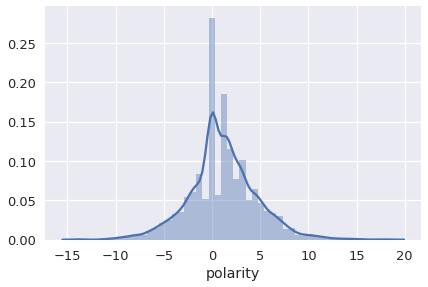

In [51]:
### make your plot here
sns.distplot(senti['polarity'])

---
<br></br>

## Polarity Over Time
Now I created a line plot of the sentiment of Trump's tweets over time and plotted the mean sentiment of each month of his tweets over time. Then, plot vertical lines corresponding to his election and inauguration dates.


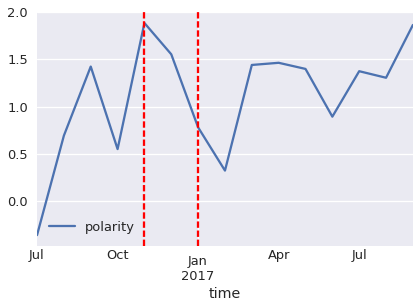

In [52]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
(senti.loc[:, ['est_time', 'polarity']].set_index('est_time').resample('M')).plot()
b = plt.axvline(pd.to_datetime('2016-11-08'), color = 'r', linestyle = 'dashed')
c = plt.axvline(pd.to_datetime('2017-01-21'), color = 'r', linestyle = 'dashed')
plt.xlabel('time')

In general, his positive sentiment seems to have increased after being elected as president. Its interesting to note the sharp dip in sentiment right after being elected, as he was probably negatively responding to all the criticism he was receiving after being voted in. Its also interesting to note how his sentiment rose before the election, as he went from being labelled as having no chance of winning the election to actually winning.

## Hashtags

Let's return now to the problem of determining which tweets were from Trump and which were from his aides. As a reminder, most analysts agree that tweets that came from an Android device were likely from Trump himself, not one of his aides ([example](http://didtrumptweetit.com/machine-learning-tweet-prediction/)).

In addition, browsing his Twitter shows that some tweets that sound more "official" often have a hashtag, link, or a picture:

![](aide.png)

Whereas tweets that sound like Trump himself usually don't have a hashtag, link, or picture:

![](trump.png)

So, we can hypothesize that if a tweet has a hashtag, link, or picture it came from one of Trump's aides, not Trump himself. Let's see if this idea is backed up by the data.

---
<br></br>

## Checking for Retweets, Hashtags, and Links

I created a DF called `hash_or_link` that contains only the rows from the `senti` table where the tweet isn't a retweet and contains a hashtag, link, or picture. We say that:

- A tweet is a retweet if it has the string 'rt' anywhere in the tweet if it is preceeded and followed by a non-word character (the start and end of the string count as non-word characters).
- A tweet has a hashtag if it has the character '#' anywhere in the tweet followed by a letter.
- A tweet contains a link or a picture if it has the word `http` anywhere in the tweet

(You can check out Trump's Twitter for why these criteria are true).

In [54]:
# You must save your regex for retweets in this variable
rt_re = r'\Wrt\W|\brt\W|\Wrt\b'
# You must save your regex for hashtags, links, or pictures in this variable
hash_re = r'#\w|http'
hash_or_link = senti[senti['text'].str.contains(hash_re)]
hash_or_link = hash_or_link[~hash_or_link['text'].str.contains(rt_re)]
hash_or_link.head()

,retweet_count,source,text,time,est_time,no_punc,polarity
912711807709667331,3956,Twitter for iPhone,honored to welcome republican and democrat mem...,2017-09-26 16:13:46,2017-09-26 12:13:46-04:00,honored to welcome republican and democrat mem...,4.8
912670906828443648,4083,Twitter for iPhone,"alabama, get out and vote for luther strange -...",2017-09-26 13:31:15,2017-09-26 09:31:15-04:00,alabama get out and vote for luther strange ...,-0.8
912487929783754755,24067,Media Studio,a few of the many clips of john mccain talking...,2017-09-26 01:24:10,2017-09-25 21:24:10-04:00,a few of the many clips of john mccain talking...,2.2
912481556127780865,7569,Twitter for iPhone,"...owed to wall street and the banks which, sa...",2017-09-26 00:58:50,2017-09-25 20:58:50-04:00,owed to wall street and the banks which sa...,0.1
912443924979077120,24756,Twitter for iPhone,tremendous backlash against the nfl and its pl...,2017-09-25 22:29:18,2017-09-25 18:29:18-04:00,tremendous backlash against the nfl and its pl...,-1.8


In [55]:
len(hash_or_link)

1329

In [57]:
trump['text'].head()

912771708544802823    rt @ricardorossello: briefed @potus @realdonal...
912711807709667331    honored to welcome republican and democrat mem...
912670906828443648    alabama, get out and vote for luther strange -...
912664574461120512    the nfl has all sorts of rules and regulations...
912651215997202432    thank you to carmen yulin cruz, the mayor of s...
Name: text, dtype: object

--- 
<br></br>

## Question 6b

Create a line plot of the number of tweets containing a hashtag, link, or picture from each tweet device.

If a device doesn't have at least 20 tweets in a particular year, don't include the tweets from that device for that year. (Eg. if there are 100 tweets from Twitter Ads in 2016 but only 10 in 2017, plot the counts for Twitter Ads in 2016 but not 2017.)

Aggregate the counts for each week period. Your final plot should look like:

![](hashtag_by_device.png)

*Hint:* If you can get a table in the following format, you can just call `.plot()` on it to generate the plot.

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>source</th>
      <th>Media Studio</th>
      <th>Twitter Ads</th>
      <th>Twitter Web Client</th>
      <th>Twitter for Android</th>
      <th>Twitter for iPhone</th>
    </tr>
    <tr>
      <th>time</th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>2016-07-24</th>
      <td>NaN</td>
      <td>NaN</td>
      <td>4.0</td>
      <td>10.0</td>
      <td>14.0</td>
    </tr>
    <tr>
      <th>2016-08-07</th>
      <td>NaN</td>
      <td>NaN</td>
      <td>5.0</td>
      <td>15.0</td>
      <td>91.0</td>
    </tr>
    <tr>
      <th>2016-08-21</th>
      <td>NaN</td>
      <td>NaN</td>
      <td>9.0</td>
      <td>10.0</td>
      <td>44.0</td>
    </tr>
    <tr>
      <th>2016-09-04</th>
      <td>NaN</td>
      <td>NaN</td>
      <td>0.0</td>
      <td>20.0</td>
      <td>51.0</td>
    </tr>
    <tr>
      <th>2016-09-18</th>
      <td>NaN</td>
      <td>NaN</td>
      <td>1.0</td>
      <td>12.0</td>
      <td>59.0</td>
    </tr>
  </tbody>
</table>

What conclusions can you draw from this plot? Does this plot allow us to say whether a tweet containing a hashtag/link/picture likely came from Trump himself? Write your takeaways in `hashtag_answer` variable.



From the graph, we can see that while Trump used to post numerous tweets from a variety of different sources, recently
he has only been Media Studio and Twitter for iPhone extensively to post tweets. Also, after becoming president, it seems
that Trump has been tweeting less often, though he still tweets consistently. 



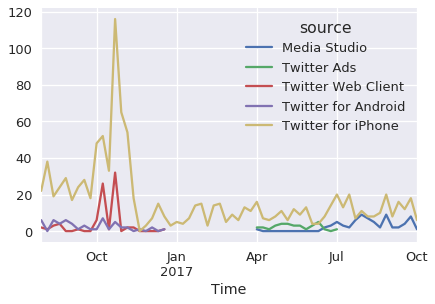

In [58]:
# Create your plot here...

L = hash_or_link['year'] = hash_or_link['est_time'].apply(lambda x: x.year)
L_filter = hash_or_link.groupby(['source', 'year']).filter(lambda x: len(x) > 20)
(L_filter.loc[:,['est_time', 'source']].set_index('est_time').groupby('source')
     .resample('W').size().unstack(level=0)).plot()
plt.xlabel('Time')


# ...then write your takeaways here.
hashtag_answer = '''

From the graph, we can see that while Trump used to post numerous tweets from a variety of different sources, recently
he has only been Media Studio and Twitter for iPhone extensively to post tweets. Also, after becoming president, it seems
that Trump has been tweeting less often, though he still tweets consistently. 

'''
display(Markdown(hashtag_answer))

--- 
<br></br>

## Question 6c 

Now, let's see whether there's a difference in sentiment for tweets with hashtags and those without.

Create a line plot of the sentiment of Trump's non-retweet tweets over time, taking the mean sentiment for every month. Plot one line for tweets with hashtags and one for tweets without. Then, draw two vertical lines for the election date and inauguration date. Draw a horizontal line for y=0. Your plot should look like:

![](hash_senti.png)

What do you notice about the plot? What conclusions can you draw? Write your answers in `hash_senti_answer`.

Hint 1: You'll want to start use your `senti` table, not your `hash_or_link` table. Try adding a column to `senti` containing True if the tweet has a hashtag/link/picture.

Hint 2: You shouldn't use your `no_punc` column. Think about why not.



From this graph, Trump's tweets seem to be more positive when he his tweets do contain hashtags or links compared to when
his tweets contain neither. It is also interesting to note how significantly the polarity of his tweets in general has increased since
he has taken office after becoming president. 



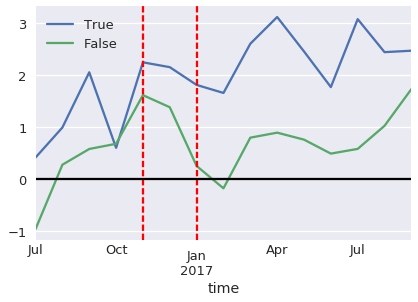

In [59]:
# Create your plot here...
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
senti['bool'] = senti['text'].str.contains(hash_re)
senti['bool2'] = senti['text'].str.contains(rt_re)
senti1 = senti[senti['bool2'] == False]
senti1_true = senti1[senti1['bool'] == True]
senti1_false = senti1[senti1['bool'] == False]
a = (senti1_true.loc[:, ['est_time', 'polarity']].set_index('est_time').resample('M'))
b = (senti1_false.loc[:, ['est_time', 'polarity']].set_index('est_time').resample('M'))
ax = a.plot()
b.plot(ax = ax)
plt.axvline(pd.to_datetime('2016-11-08'), color = 'r', linestyle = 'dashed')
plt.axvline(pd.to_datetime('2017-01-21'), color = 'r', linestyle = 'dashed')
plt.axhline(y = 0, color = 'black')
plt.xlabel('time')
ax.legend(['True', 'False'])

# ...then write your takeaways here.
hash_senti_answer = '''

From this graph, Trump's tweets seem to be more positive when he his tweets do contain hashtags or links compared to when
his tweets contain neither. It is also interesting to note how significantly the polarity of his tweets in general has increased since
he has taken office after becoming president. 

'''
display(Markdown(hash_senti_answer))

--- 

## Question 7: Engagement

---
<br></br>
## Question 7a

Which of Trump's tweets had the most retweets? Were there certain words that often led to more retweets?

We can find this out by using our `tidy_format` DataFrame. For each word in the `tidy_format` DF, find out the number of retweets that its tweet got. Filter out words that didn't appear in at least 25 tweets, find out the median number of retweets each word got, and save the top 20 most retweeted words into a DataFrame called `top_20`. Your `top_20` table should have this format:

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>retweet_count</th>
    </tr>
    <tr>
      <th>word</th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>fake</th>
      <td>22963.0</td>
    </tr>
    <tr>
      <th>news</th>
      <td>20463.0</td>
    </tr>
    <tr>
      <th>ds100</th>
      <td>20432.0</td>
    </tr>
    <tr>
      <th>great</th>
      <td>20159.0</td>
    </tr>
    <tr>
      <th>class</th>
      <td>20121.0</td>
    </tr>
  </tbody>
</table>

In [60]:
tidy_format.head()
top_20 = tidy_format.copy()
top_20["retweet_count"] = [trump.loc[i, "retweet_count"] for i in tidy_format.index.values]
top_20 = top_20.groupby("word").filter(lambda x: len(x) >= 25)
top_20 = top_20.loc[:,["word", "retweet_count"]]
top_20 = top_20.groupby("word").median()
top_20 = top_20.sort_values("retweet_count", ascending = False)
top_20 = top_20.head(20)
top_20.head()

,retweet_count
word,
fake,22945.5
russia,21186.0
korea,20810.0
place,20627.0
should,20537.0


In [61]:
_ = ok.grade('q07a')
_ = ok.backup()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'proj1.ipynb'.
Submit... 0.0% complete
Could not submit: Late Submission of cal/ds100/fa17/proj1_part1
Backup... 100% complete



Here's a bar chart of your results:

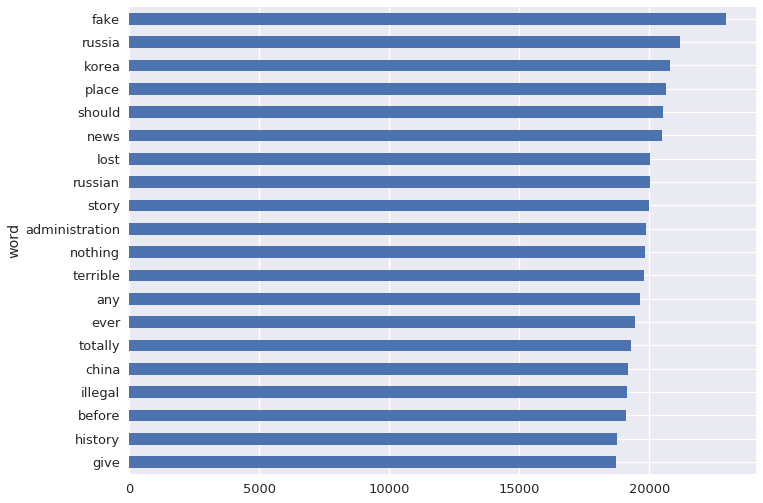

In [62]:
top_20['retweet_count'].sort_values().plot.barh(figsize=(10, 8))

---
<br></br>

## Question 7b

The phrase "fake news" is apparently really popular! We can conclude that Trump's tweets containing "fake" and/or "news" result in the most retweets relative to words his other tweets. Or can we?

Consider each of the statements about possible confounding factors below. State whether each statement is true or false and explain. If the statement is true, state whether the confounding factor could have made "fake" and/or "news" higher on our list than they should be.

1. We didn't restrict our word list to nouns, so we have unhelpful words like "let" and "any" in our result.
1. We didn't remove hashtags in our text, so we have duplicate words (eg. #great and great).
1. We didn't account for the fact that Trump's follower count has increased over time.

In [63]:
engagement_answer = '''

1. True. However, this is not a confounding factor because taking a subset of nouns won't affect the ranking. 
2. False, all special characters were replaced with whitespace.
3. True, since he probably gained many followers after being elected president. And since fake news more recently became his tagline,
this could definitely be inflating the numbers and make the words appear more popular than they actually are. 

'''
display(Markdown(engagement_answer))



1. True. However, this is not a confounding factor because taking a subset of nouns won't affect the ranking. 
2. False, all special characters were replaced with whitespace.
3. True, since he probably gained many followers after being elected president. And since fake news more recently became his tagline,
this could definitely be inflating the numbers and make the words appear more popular than they actually are. 



---
## Question 8: Fake News

---
<br></br>
## Question 8a 

Let's investigate the term "fake news" a bit more. Create a table called `fake_counts` that has two columns:

1. `fake_news`: The number of tweets containing the term "fake news".
1. `total`: The total number of tweets for the time period.

The index of the table should be datetimes for each two-week period in the data.

The resulting table should look like:

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>fake_news</th>
      <th>total</th>
    </tr>
    <tr>
      <th>time</th>
      <th></th>
      <th></th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>2016-07-31</th>
      <td>0</td>
      <td>79</td>
    </tr>
    <tr>
      <th>2016-08-14</th>
      <td>0</td>
      <td>143</td>
    </tr>
    <tr>
      <th>2016-08-28</th>
      <td>0</td>
      <td>118</td>
    </tr>
    <tr>
      <th>2016-09-11</th>
      <td>0</td>
      <td>121</td>
    </tr>
    <tr>
      <th>2016-09-25</th>
      <td>0</td>
      <td>111</td>
    </tr>
  </tbody>
</table>

In [64]:
temp = senti.copy()
temp['fake_counts_bool'] = temp['text'].str.contains('fake news')
temp_true = temp[temp['fake_counts_bool'] == True]
a = (temp_true.loc[:, ['est_time', 'fake_counts_bool']].set_index('est_time')
     .resample('2W-SUN', closed = 'left')).count()
b = (temp.loc[:, ['est_time', 'fake_counts_bool']].set_index('est_time').resample('2W-SUN')).count()
fake_counts = pd.concat([a, b], axis=1).fillna(0)
fake_counts.columns = (['fake_news', 'total'])
fake_counts.index = pd.DatetimeIndex(fake_counts.index).date
fake_counts

,fake_news,total
2016-07-31,0.0,68
2016-08-14,0.0,144
2016-08-28,0.0,116
2016-09-11,0.0,121
2016-09-25,0.0,113
2016-10-09,0.0,255
2016-10-23,0.0,264
2016-11-06,0.0,167
2016-11-20,0.0,66
2016-12-04,0.0,76


In [65]:
_ = ok.grade('q08a')
_ = ok.backup()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'proj1.ipynb'.
Submit... 0.0% complete
Could not submit: Late Submission of cal/ds100/fa17/proj1_part1
Backup... 100% complete



--- 
<br></br>

## Question 8b

Now, create a line plot showing the proportion of tweets containing the term "fake news" over time. Then, draw two vertical lines corresponding to the election and inauguration dates.

What do you notice? Write your conclusions in `fake_news_answer`.



The famous term of fake news seems to only have originated after Trump was elected, since it had 0 usage before. It seems
to have stuck thanks to Trump's constant criticism of news outlets as 'fake news', and news outlets' criticism of Trump
as well. However, it seems to have decreased as of recently compared to previous months. 



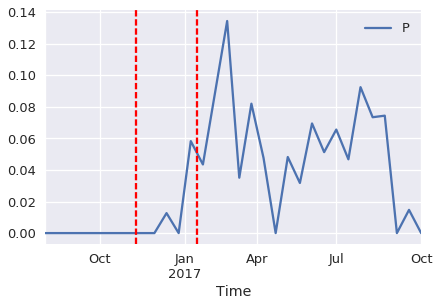

In [66]:
# Create your plot here...

c = (temp.loc[:, ['est_time', 'fake_counts_bool']].set_index('est_time').resample('2W-SAT')).plot()
c.legend('Prop')
plt.axvline(pd.to_datetime('2016-11-08'), color = 'r', linestyle = 'dashed')
plt.axvline(pd.to_datetime('2017-01-21'), color = 'r', linestyle = 'dashed')
plt.xlabel('Time')

# ...then write your takeaways here.
fake_news_answer = '''

The famous term of fake news seems to only have originated after Trump was elected, since it had 0 usage before. It seems
to have stuck thanks to Trump's constant criticism of news outlets as 'fake news', and news outlets' criticism of Trump
as well. However, it seems to have decreased as of recently compared to previous months. 

'''
display(Markdown(fake_news_answer))

## Submission

Congrats, you just finished Project 1!

Run the cell below to run all the OkPy tests at once:

In [67]:
import os
print("Running all tests...")
_ = [ok.grade(q[:-3]) for q in os.listdir("ok_tests") if q.startswith('q')]

Running all tests...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running t

Now, run the cell below to submit your assignment to OkPy. The autograder should email you shortly with your autograded score. The autograder will only run once every 30 minutes.

**If you're failing tests on the autograder but pass them locally**, you should simulate the autograder by doing the following:

1. In the top menu, click Kernel -> Restart and Run all.
2. Run the cell above to run each OkPy test.

**You must make sure that you pass all the tests when running steps 1 and 2 in order.** If you are still failing autograder tests, you should double check your results.

In [68]:
_ = ok.submit()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'proj1.ipynb'.
Submit... 0.0% complete
Could not submit: Late Submission of cal/ds100/fa17/proj1_part1
Backup... 100% complete

